In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.options.display.max_rows = 10
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor

In [2]:
unusuals_df = pd.read_csv("CompleteHatAndPricingData.csv")
unusuals_df = unusuals_df[unusuals_df.columns.drop("Unnamed: 0")]
unusuals_df

,Name,Effect,Price,Class,Item Type,Equip Region,Grade,Unboxed From,Robo,Generation,Effect Community Rating,Crate Cosmetic,Months Since Last Price Update,Effect Median Price,Hat Median Price,Hat Rating,Effect Rating,Median Effect Rating,Median Hat Rating
0,Dread Knot,Burning Flames,30.0,Heavy,Cosmetic,Regular,No Grade,Old Series,False,First Gen,4.575758,True,9,104.00,14.0,-7.40,1.6,6.7375,-1.6000
1,Dread Knot,Circling Heart,NaN,Heavy,Cosmetic,Regular,No Grade,Old Series,False,First Gen,3.060606,True,-1,36.25,14.0,NaN,NaN,0.4500,-1.6000
2,Dread Knot,Circling Peace Sign,10.0,Heavy,Cosmetic,Regular,No Grade,Old Series,False,First Gen,2.242424,True,21,22.00,14.0,-1.20,-0.4,-0.8500,-1.6000
3,Dread Knot,Circling TF Logo,9.0,Heavy,Cosmetic,Regular,No Grade,Old Series,False,First Gen,2.393939,True,44,21.50,14.0,-1.25,-0.5,-0.9125,-1.6000
4,Dread Knot,Green Confetti,9.0,Heavy,Cosmetic,Regular,No Grade,Old Series,False,First Gen,1.393939,True,15,17.00,14.0,-0.80,-0.5,-1.4000,-1.6000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41276,Snowcapped,Magnetic Hat Protector,NaN,Medic,Cosmetic,Regular,Mercenary,Winter 2018 Cosmetic,False,Invasion,2.212121,False,-1,20.50,22.0,NaN,NaN,-0.9000,-0.1625
41277,Snowcapped,Voltaic Hat Protector,NaN,Medic,Cosmetic,Regular,Mercenary,Winter 2018 Cosmetic,False,Invasion,2.151515,False,-1,52.50,22.0,NaN,NaN,-1.1750,-0.1625
41278,Snowcapped,Galactic Codex,NaN,Medic,Cosmetic,Regular,Mercenary,Winter 2018 Cosmetic,False,Invasion,1.545455,False,-1,36.75,22.0,NaN,NaN,-1.1000,-0.1625
41279,Snowcapped,Ancient Codex,NaN,Medic,Cosmetic,Regular,Mercenary,Winter 2018 Cosmetic,False,Invasion,1.575758,False,-1,19.50,22.0,NaN,NaN,-1.2500,-0.1625


In [3]:
unusuals_train_df = unusuals_df[~unusuals_df["Price"].isnull()]
unusuals_predict_df = unusuals_df[unusuals_df["Price"].isnull()]

In [4]:
cross_val_subset = unusuals_train_df[(unusuals_train_df["Equip Region"] == "Regular") & (unusuals_train_df["Price"] <= 2000)]

In [5]:
feature_set = cross_val_subset.columns.drop(["Price","Effect","Unboxed From","Months Since Last Price Update",
                                             "Effect Median Price","Hat Median Price","Hat Rating","Effect Rating"])
feature_set

Index(['Name', 'Class', 'Item Type', 'Equip Region', 'Grade', 'Robo',
       'Generation', 'Effect Community Rating', 'Crate Cosmetic',
       'Median Effect Rating', 'Median Hat Rating'],
      dtype='object')

## KNN

In [6]:
def get_KNN_error(k):
    X_train = df[feature_set]
    X_dict = df[feature_set].to_dict(orient = "records")
    y_train = df["Price"]
    
    vec = DictVectorizer(sparse=False)
    scaler = StandardScaler()
    model1 = KNeighborsRegressor(n_neighbors=k,metric = "manhattan")
    
    model_1_pipeline = Pipeline([("vectorizer",vec),("scaler",scaler),("fit",model1)])
    
    scores_1 = cross_val_score(model_1_pipeline, X_dict, y_train,
                               cv=2, scoring="neg_mean_squared_error")
    
    return np.sqrt(np.mean(-scores_1))

6     71.828786
7     71.871905
5     72.159415
8     72.259563
9     72.281267
        ...    
22    74.846768
23    74.948311
24    75.106722
25    75.238484
1     77.034258
Length: 25, dtype: float64

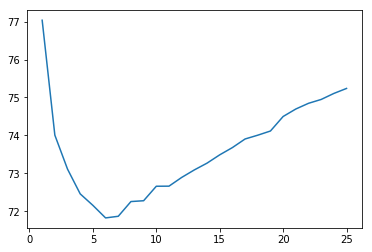

In [7]:
df = cross_val_subset
ks = pd.Series(range(1, 26))
ks.index = range(1, 26)
test_errs = ks.apply(get_KNN_error)

test_errs.plot.line()
test_errs.sort_values()

## Random Forest

In [8]:
def get_RandomForest_error(n):
    X_train = df[feature_set]
    X_dict = df[feature_set].to_dict(orient = "records")
    y_train = df["Price"]
    
    vec = DictVectorizer(sparse=False)
    scaler = StandardScaler()
    model2 = RandomForestRegressor(n_estimators=n, max_depth=10, min_samples_leaf=5)
    
    model_2_pipeline = Pipeline([("vectorizer",vec),("scaler",scaler),("fit",model2)])
    
    scores_2 = cross_val_score(model_2_pipeline, X_dict, y_train,
                               cv=2, scoring="neg_mean_squared_error")
    
    return np.sqrt(np.mean(-scores_2))

21    49.332397
25    49.511418
20    49.689005
8     49.710666
11    49.715013
        ...    
4     51.596177
9     51.999738
2     52.341782
1     53.668489
3     55.385561
Length: 25, dtype: float64

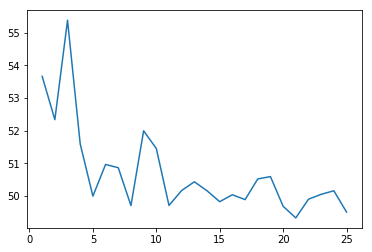

In [9]:
df = cross_val_subset
ks = pd.Series(range(1, 26))
ks.index = range(1, 26)
test_errs = ks.apply(get_RandomForest_error)

test_errs.plot.line()
test_errs.sort_values()

## Ensemble Models

In [10]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.linear_model import LinearRegression

class RegressionEnsembler(BaseEstimator, RegressorMixin):
    """Creates an ensemble model out of a collection of individual estimators
    
    Args:
      estimators: A list containing the individual estimators.
      learn_weights: A boolean that specifies whether we should learn the
        "optimal" weights/coefficients to apply to each individual estimator's
        predictions. If False, we simply return the straight average of the 
        individual estimators' predictions as the ensemble prediction.
    """
    
    def __init__(self, estimators, learn_weights=True):
        self.estimators = estimators
        self.learn_weights = learn_weights
        self.vec = DictVectorizer(sparse=False)
        self.scaler = StandardScaler()
        
    def fit(self, X, y):
        
        # store the training features and the labels
        self.X_ = X
        self.y_ = y
        
        # call the fit method of each of the estimators
        for estimator in self.estimators:
            #X_train_dict = X.to_dict(orient = "records")
            
            estimator.fit(X, y) #X_train_sc
            
        # if we wish to learn the "optimal" weights from the training data
        if self.learn_weights:
            # get prediction from each estimator on the training data
            predictions = []
            for estimator in self.estimators:
                predictions.append(estimator.predict(X))
            Y_ = np.column_stack(predictions)
        
            # fit linear regression on top of the estimators' predictions
            self.ensembler = LinearRegression(fit_intercept=False)
            self.ensembler.fit(Y_, y)
            
        return self
    
    def predict(self, X):
        # check that fit has been called
        check_is_fitted(self, ['X_', 'y_'])
        
        # calculate predictions from the estimators
        predictions = []
        for estimator in self.estimators:
            
            #print(estimator.predict(X_pred_sc))
            predictions.append(estimator.predict(X))
        Y_ = np.column_stack(predictions)
        
        # return predictions
        if self.learn_weights:
            return self.ensembler.predict(Y_)
        else:
            return Y_.mean(axis=1)

In [11]:
def get_error_from_feature_set(feature_set,df):
    X_train = df[feature_set]
    X_dict = df[feature_set].to_dict(orient = "records")
    y_train = df["Price"]
    
    vec = DictVectorizer(sparse=False)
    scaler = StandardScaler()
    model1 = KNeighborsRegressor(n_neighbors=6,metric = "manhattan") # k = 6 is the best hyperparameter
    model2 = RandomForestRegressor(n_estimators=21) # n = 21 is the best hyperparameter
    model3 = BaggingRegressor()
    
    model_1_pipeline = Pipeline([("vectorizer",vec),("scaler",scaler),("fit",model1)])
    model_2_pipeline = Pipeline([("vectorizer",vec),("scaler",scaler),("fit",model2)])
    model_3_pipeline = Pipeline([("vectorizer",vec),("scaler",scaler),("fit",model3)])
    
    scores_1 = cross_val_score(model_1_pipeline, X_dict, y_train,
                               cv=3, scoring="neg_mean_squared_error")
    scores_2 = cross_val_score(model_2_pipeline, X_dict, y_train,
                               cv=3, scoring="neg_mean_squared_error")
    
    scores_3 = cross_val_score(model_3_pipeline, X_dict, y_train,
                               cv=3, scoring="neg_mean_squared_error")
        
    ensemble_model_1 = RegressionEnsembler([model_1_pipeline, model_2_pipeline,model_3_pipeline],learn_weights=False)
    ensemble_model_2 = RegressionEnsembler([model_1_pipeline, model_2_pipeline,model_3_pipeline],learn_weights=True)
    
    scores_4 = cross_val_score(ensemble_model_1, X_dict, y_train, cv=3, scoring="neg_mean_squared_error")
    scores_5 = cross_val_score(ensemble_model_2, X_dict, y_train, cv=3, scoring="neg_mean_squared_error")
    
    return [np.sqrt(np.mean(-scores_1)),np.sqrt(np.mean(-scores_2)),np.sqrt(np.mean(-scores_3)),np.sqrt(np.mean(-scores_4)),np.sqrt(np.mean(-scores_5))]

In [12]:
get_error_from_feature_set(feature_set,cross_val_subset)

[66.829677217963095,
 51.807532602829291,
 50.572563835405319,
 51.448706145328977,
 52.951252061407487]

While the bagging model has the lowest individual cross val score, it is less than accurate at predicting low value unusuals. To offset this, I am including KNN and random forest into an ensemble model for my final predictions.

## Final Predictions

In [13]:
def predict_set(feature_set,train_df,predict_df):
    
    X_dict = train_df[feature_set].to_dict(orient = "records")
    X_validation_dict = predict_df[feature_set].to_dict(orient = "records")
    y = train_df["Price"]
    y_validation = predict_df["Price"]
    
    vec = DictVectorizer(sparse=False)
    vec.fit(X_dict)
    X_train = vec.transform(X_dict)
    X_validation = vec.transform(X_validation_dict)
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)
        
    model_1 = KNeighborsRegressor(n_neighbors=5,metric = "manhattan")
    model_1.fit(X_train_scaled,y)
    y_validation_pred_model_1 = model_1.predict(X_validation_scaled)
    
    model_2 = RandomForestRegressor(n_estimators=50) 
    model_2.fit(X_train_scaled,y)
    y_validation_pred_model_2 = model_2.predict(X_validation_scaled)
    
    model_3 = BaggingRegressor()
    model_3.fit(X_train_scaled,y)
    y_validation_pred_model_3 = model_3.predict(X_validation_scaled)
    
    model_1_pipeline = Pipeline([("vectorizer",vec),("scaler",scaler),("fit",model_1)])
    model_2_pipeline = Pipeline([("vectorizer",vec),("scaler",scaler),("fit",model_2)])
    model_3_pipeline = Pipeline([("vectorizer",vec),("scaler",scaler),("fit",model_3)])
    
    ensemble_model_1 = RegressionEnsembler([model_1_pipeline, model_2_pipeline,model_3_pipeline],learn_weights=False)
    ensemble_model_2 = RegressionEnsembler([model_1_pipeline, model_2_pipeline,model_3_pipeline],learn_weights=True)
    
    ensemble_model_1.fit(X_dict,y)
    y_validation_pred_model_4 = ensemble_model_1.predict(X_validation_dict)
    
    ensemble_model_2.fit(X_dict,y)
    y_validation_pred_model_5 = ensemble_model_2.predict(X_validation_dict)
    
    return [y_validation_pred_model_1, y_validation_pred_model_2,y_validation_pred_model_3,y_validation_pred_model_4,y_validation_pred_model_5]

In [14]:
prediction_results = predict_set(feature_set,unusuals_train_df,unusuals_predict_df)
prediction_results

[array([ 10.9 ,   9.2 ,   8.45, ...,  20.4 ,  20.3 ,  51.8 ]),
 array([  17.11 ,    9.62 ,    8.785, ...,   20.5  ,   15.57 ,  112.34 ]),
 array([  13.4  ,    9.025,    9.05 , ...,   21.6  ,   16.2  ,  108.55 ]),
 array([ 14.56333333,   9.38833333,   8.58833333, ...,  20.85666667,
         17.08333333,  95.22      ]),
 array([  16.83563886,    9.80607427,    9.09120424, ...,   21.28085373,
          15.21625727,  137.59711948])]

In [15]:
pd.DataFrame(np.array(prediction_results).T)

,0,1,2,3,4
0,10.90,17.110,13.400,14.563333,16.835639
1,9.20,9.620,9.025,9.388333,9.806074
2,8.45,8.785,9.050,8.588333,9.091204
3,32.40,58.880,55.700,48.740000,62.134218
4,32.40,55.020,59.900,46.423333,58.905842
...,...,...,...,...,...
24687,21.00,20.290,21.150,20.060000,20.874462
24688,20.80,16.940,17.000,18.026667,16.804386
24689,20.40,20.500,21.600,20.856667,21.280854
24690,20.30,15.570,16.200,17.083333,15.216257


In [16]:
unusuals_final_predictions_df = (pd.concat([unusuals_predict_df.reset_index(),pd.DataFrame(np.array(prediction_results).T)],axis = 1).
                                rename(columns = {0:"Predicted Price KNN",1:"Predicted Price Forest",2:"Predicted Price Bagging",3:"Learn Weights = False",4:"Learn Weights = True"}))
unusuals_final_predictions_df = unusuals_final_predictions_df[unusuals_final_predictions_df.columns.drop("Price")]

In [17]:
unusuals_final_predictions_df_short = unusuals_final_predictions_df[["Name","Effect","Predicted Price KNN", "Predicted Price Forest","Predicted Price Bagging","Learn Weights = False",
                                                                                     "Learn Weights = True"]]
unusuals_final_predictions_df_short

,Name,Effect,Predicted Price KNN,Predicted Price Forest,Predicted Price Bagging,Learn Weights = False,Learn Weights = True
0,Dread Knot,Circling Heart,10.90,17.110,13.400,14.563333,16.835639
1,Dread Knot,Purple Confetti,9.20,9.620,9.025,9.388333,9.806074
2,Dread Knot,Orbiting Planets,8.45,8.785,9.050,8.588333,9.091204
3,Dread Knot,Harvest Moon,32.40,58.880,55.700,48.740000,62.134218
4,Dread Knot,It's A Secret To Everybody,32.40,55.020,59.900,46.423333,58.905842
...,...,...,...,...,...,...,...
24687,Snowcapped,Magnetic Hat Protector,21.00,20.290,21.150,20.060000,20.874462
24688,Snowcapped,Voltaic Hat Protector,20.80,16.940,17.000,18.026667,16.804386
24689,Snowcapped,Galactic Codex,20.40,20.500,21.600,20.856667,21.280854
24690,Snowcapped,Ancient Codex,20.30,15.570,16.200,17.083333,15.216257


In [18]:
unusuals_final_predictions_df[unusuals_final_predictions_df.columns.drop(["index","Predicted Price KNN","Predicted Price Forest",
                                                                          "Predicted Price Bagging","Learn Weights = True"])].rename(
                                                                            columns = {"Learn Weights = False" : "Price"}).to_csv("Predictions.csv")